# COCO Image Dataset Testing

## Imports

In [1]:
# Add Utils to path
import sys
sys.path.append('../Utils')  # Adds higher directory to python modules path.

# Utils
from datasets_generators import CocoDetection
from plot_coco_image import plot_coco_image
from image_enhancement_functions import clahe

# Pytorch
import torchvision.transforms as T
from transformers import DetrImageProcessor

# Other
import os
import cv2
import json
import random
from PIL import ImageDraw
import matplotlib.pyplot as plt

## Load Data

In [2]:
# Paths
imgs_path = "../ExDark_All/Images"
coco_path = "../ExDark_COCO/3200-1800-rest/train_set.json"

# Transforms
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# COCO Dataset
coco_dataset = CocoDetection(image_directory_path=imgs_path,  annotation_file_path=coco_path, image_processor=image_processor)

# Data
print("Number of images: ", len(coco_dataset))
print("Number of classes: ", len(coco_dataset.coco.getCatIds()))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Number of images:  3000
Number of classes:  12


# Plots

## Testing Data Processing
Original image vs Facebook Pretrained vs Custom Preprocessing

Facebook Image Shape: torch.Size([3, 800, 1066])
Facebook Anno: {'size': tensor([ 800, 1066]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[0.6790, 0.3320, 0.5420, 0.5147]]), 'area': tensor([237888.]), 'iscrowd': tensor([0]), 'orig_size': tensor([375, 500])}

Custom Image Shape: torch.Size([3, 500, 500])
Custom Anno: {'size': tensor([500, 500]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[204.,  37., 271., 258.]]), 'area': tensor([69918.])}


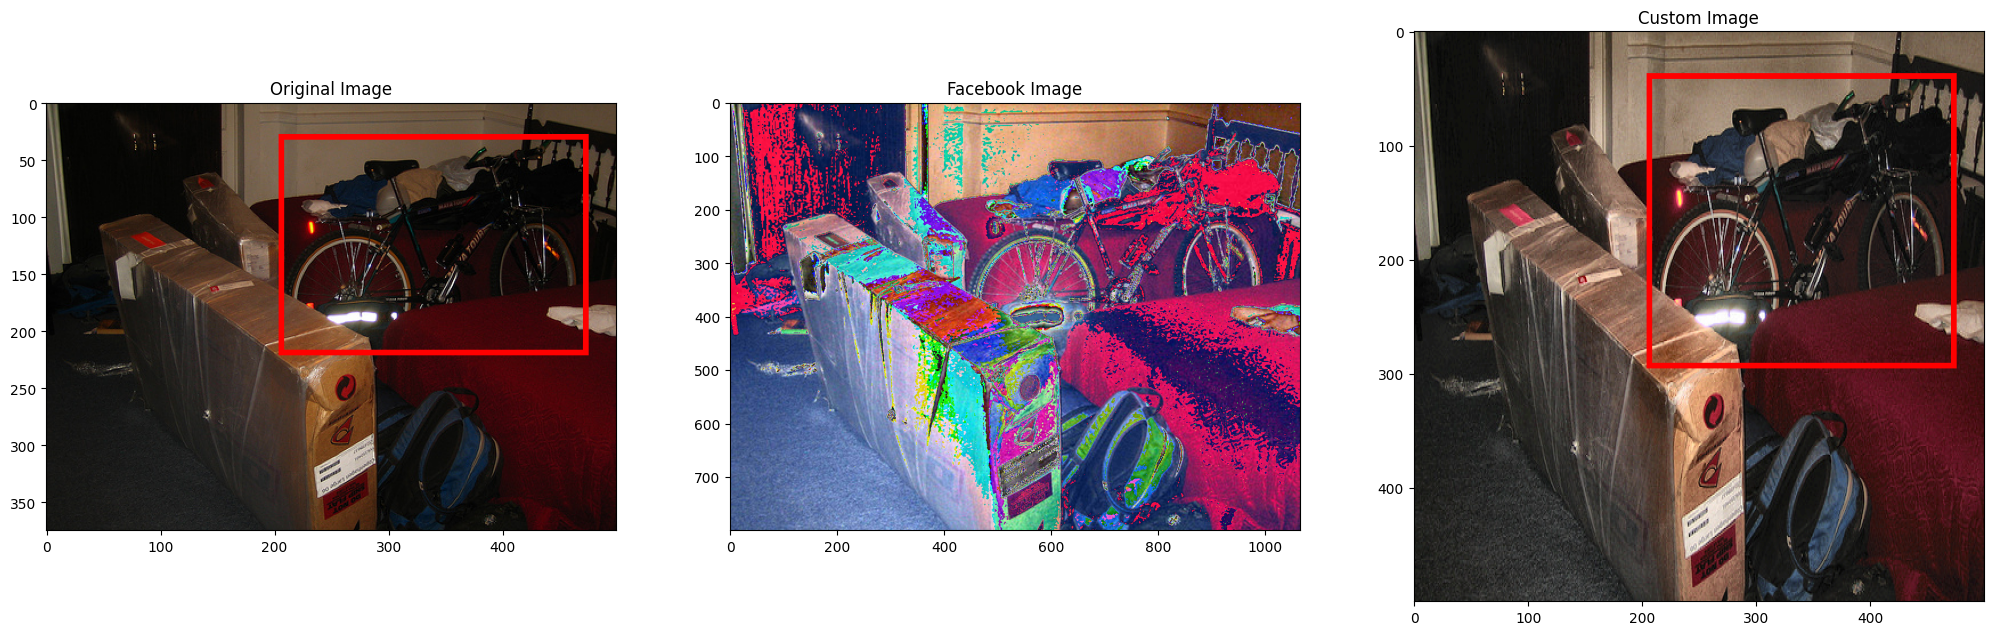

In [3]:
image_id = 0
to_pil_image = T.ToPILImage()

# Original Image
with open(coco_path) as f:
  data = json.load(f)
image_name = data['images'][image_id]['file_name']
og_img = cv2.imread(os.path.join(imgs_path, image_name))
og_img = cv2.cvtColor(og_img, cv2.COLOR_BGR2RGB)
og_img = to_pil_image(og_img)
og_box = [int(b) for b in data['annotations'][image_id]['bbox']]
og_box = [og_box[0], og_box[1], og_box[0]+og_box[2], og_box[1]+og_box[3]]
og_draw = ImageDraw.Draw(og_img)
og_draw.rectangle(og_box, outline='red', width=5)

# Preprocessed Images
fb_image, fb_anno, ct_image, ct_anno =  coco_dataset[image_id]
print("Facebook Image Shape:", fb_image.shape)
print("Facebook Anno:", fb_anno)
print("\nCustom Image Shape:", ct_image.shape)
print("Custom Anno:", ct_anno)
fb_image = to_pil_image(fb_image)
ct_image = to_pil_image(ct_image)
ct_box = [int(b) for b in ct_anno['boxes'][0]]
ct_box = [ct_box[0], ct_box[1], ct_box[0]+ct_box[2], ct_box[1]+ct_box[3]]
ct_draw = ImageDraw.Draw(ct_image)
ct_draw.rectangle(ct_box, outline='red', width=5)

# Plot
plt.figure(figsize=(25,15))
plt.subplot(1,3,1)
plt.imshow(og_img)
plt.title("Original Image")
plt.subplot(1,3,2)
plt.imshow(fb_image)
plt.title("Facebook Image")
plt.subplot(1,3,3)
plt.imshow(ct_image)
plt.title("Custom Image")
plt.show()

Random Picture


Image ID:  2619 Image:  2015_06365.jpg

Ground Truth Annotations: 
{'id': 8548, 'image_id': 2619, 'category_id': 10, 'bbox': ['272', '203', '60', '161'], 'area': 9660.0} Category Label:  People
{'id': 8549, 'image_id': 2619, 'category_id': 10, 'bbox': ['201', '198', '60', '167'], 'area': 10020.0} Category Label:  People
{'id': 8550, 'image_id': 2619, 'category_id': 10, 'bbox': ['147', '200', '63', '166'], 'area': 10458.0} Category Label:  People
{'id': 8551, 'image_id': 2619, 'category_id': 10, 'bbox': ['6', '204', '36', '140'], 'area': 5040.0} Category Label:  People
{'id': 8552, 'image_id': 2619, 'category_id': 10, 'bbox': ['35', '186', '66', '155'], 'area': 10230.0} Category Label:  People
{'id': 8553, 'image_id': 2619, 'category_id': 4, 'bbox': ['425', '229', '198', '139'], 'area': 27522.0} Category Label:  Car
{'id': 8554, 'image_id': 2619, 'category_id': 4, 'bbox': ['577', '225', '83', '74'], 'area': 6142.0} Category Label:  Car
{'id': 8555, 'image_id': 2619, 'category_id': 4, '

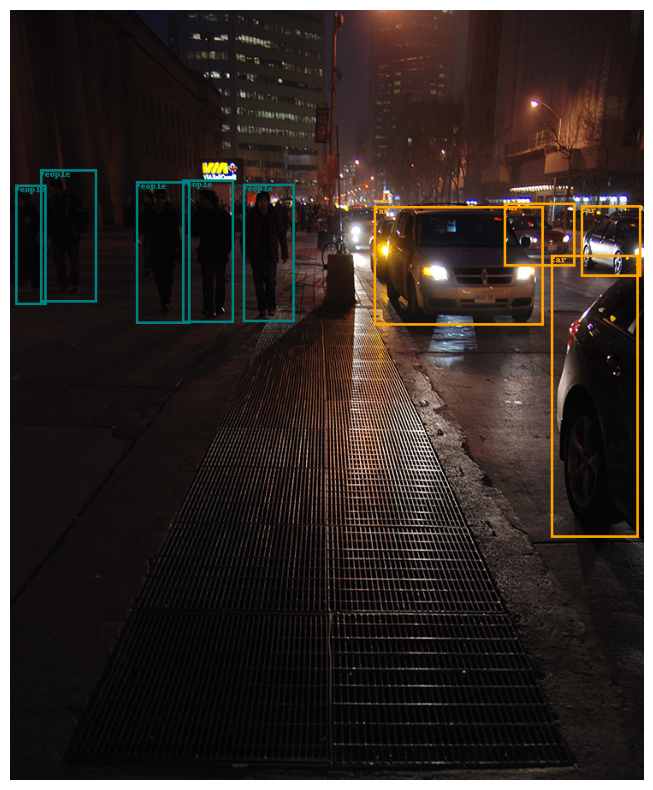

In [4]:
# Randomly plot an image
random.seed(42)
image_id = random.randint(0, len(coco_dataset))
plt.figure(figsize=(10, 10)) 
plot_coco_image(coco_dataset, imgs_path, image_id, width=3)
plt.axis('off')
plt.show()